### Comparison of different nn architectures for scene classification 

- fine tuninig
- feature extraction

Comparison results of 5 models are shown in the table below.


In [ ]:
import pandas as pd

# dictionary summary of model results
data = {
    'Model Type': ['Fine-tuned ResNet-18', 'Feature-extracted ResNet-18', 'Fine-tuned VGG-16', 'Feature-extracted VGG-16', 'Model without initial weights'],
    'Validation Accuracy': [0.9523, 0.8746, 0.9587, 0.9063, 0.5904],
    'Test Accuracy': [0.9524,0.8643,0.9524, 0.8952, 0.5476],
    'Time to Train': ['4m 4s', '3m 5s', '13m 55s', '6m 32s', '3m 26s'],
    'Number of Trainable Parameters': [11187285, 10773, 134346581, 86037, 25712341]
}

df = pd.DataFrame(data)
df

# Data preproccesing

In [ ]:
! unzip "/content/drive/MyDrive/IA/transfer_6394502_files_0a0e2750.zip"

Archive:  /content/drive/MyDrive/IA/transfer_6394502_files_0a0e2750.zip
 extracting: UCMerced.zip            
 extracting: EuroSAT.zip             


In [ ]:
! unzip UCMerced.zip

Archive:  UCMerced.zip
   creating: UCMerced/test/
   creating: UCMerced/test/agricultural/
  inflating: UCMerced/test/agricultural/agricultural03.tif  
  inflating: UCMerced/test/agricultural/agricultural04.tif  
  inflating: UCMerced/test/agricultural/agricultural11.tif  
  inflating: UCMerced/test/agricultural/agricultural13.tif  
  inflating: UCMerced/test/agricultural/agricultural14.tif  
  inflating: UCMerced/test/agricultural/agricultural17.tif  
  inflating: UCMerced/test/agricultural/agricultural27.tif  
  inflating: UCMerced/test/agricultural/agricultural28.tif  
  inflating: UCMerced/test/agricultural/agricultural29.tif  
  inflating: UCMerced/test/agricultural/agricultural31.tif  
  inflating: UCMerced/test/agricultural/agricultural35.tif  
  inflating: UCMerced/test/agricultural/agricultural54.tif  
  inflating: UCMerced/test/agricultural/agricultural64.tif  
  inflating: UCMerced/test/agricultural/agricultural69.tif  
  inflating: UCMerced/test/agricultural/agricultural75

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "/content/UCMerced"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

FileNotFoundError: ignored

In [ ]:
from torchvision import datasets, transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "/content/UCMerced"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


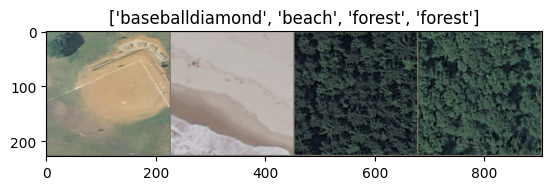

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Define functions

## Training the model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

## Visualizing the model predictions

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Evaluate the model

In [ ]:
def calculate_test_accuracy(model):
    was_training = model.training
    model.eval()
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            correct_predictions += torch.sum(preds == labels.data)

    model.train(mode=was_training)
    accuracy = correct_predictions.double() / len(dataloaders['test'].dataset)
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy



# ResNet18

## Fine tuning ResNet18

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 21)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


In [ ]:
model_ft_ResNet18 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.9518 Acc: 0.4267
val Loss: 0.7002 Acc: 0.7667

Epoch 1/24
----------
train Loss: 1.0892 Acc: 0.6562
val Loss: 0.4668 Acc: 0.8397

Epoch 2/24
----------
train Loss: 0.9024 Acc: 0.7457
val Loss: 0.4320 Acc: 0.8635

Epoch 3/24
----------
train Loss: 0.7732 Acc: 0.7733
val Loss: 0.4433 Acc: 0.8698

Epoch 4/24
----------
train Loss: 0.7921 Acc: 0.7638
val Loss: 0.2794 Acc: 0.9048

Epoch 5/24
----------
train Loss: 0.7138 Acc: 0.7829
val Loss: 0.3848 Acc: 0.8810

Epoch 6/24
----------
train Loss: 0.7039 Acc: 0.8067
val Loss: 0.3217 Acc: 0.8937

Epoch 7/24
----------
train Loss: 0.5105 Acc: 0.8552
val Loss: 0.1637 Acc: 0.9540

Epoch 8/24
----------
train Loss: 0.4418 Acc: 0.8790
val Loss: 0.1534 Acc: 0.9476

Epoch 9/24
----------
train Loss: 0.4048 Acc: 0.8771
val Loss: 0.1773 Acc: 0.9444

Epoch 10/24
----------
train Loss: 0.4223 Acc: 0.8886
val Loss: 0.1358 Acc: 0.9508

Epoch 11/24
----------
train Loss: 0.3881 Acc: 0.8867
val Loss: 0.1423 Acc: 0.9556

Ep

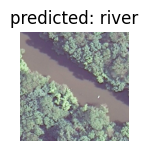

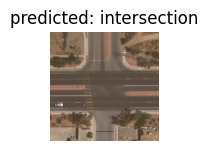

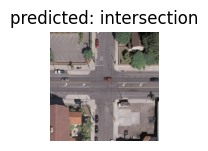

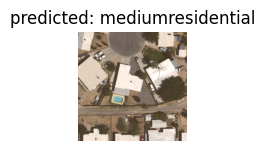

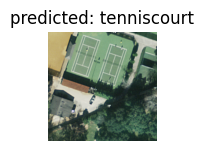

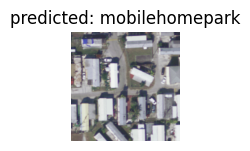

In [ ]:
# Visualize predicted classes
visualize_model(model_ft_ResNet18)

plt.ioff()
plt.show()

In [ ]:
# Test
test_accuracy = calculate_test_accuracy(model_ft_ResNet18)

Test Accuracy: 0.9476


In [ ]:
# Number of parameters
params = sum(p.numel() for p in model_ft_ResNet18.parameters())

trainable_params = sum(p.numel() for p in model_ft_ResNet18.parameters() if p.requires_grad)

print(f'Number of parameters in the model: {params}')
print(f'Number of trainable parameters in the model: {trainable_params}')

Number of parameters in the model: 11187285
Number of trainable parameters in the model: 11187285


## Feature extraction  ResNet18

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 21)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv_ResNet18 = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.4933 Acc: 0.2838
val Loss: 1.3955 Acc: 0.5937

Epoch 1/24
----------
train Loss: 1.6095 Acc: 0.5457
val Loss: 1.0194 Acc: 0.6937

Epoch 2/24
----------
train Loss: 1.3714 Acc: 0.6076
val Loss: 0.6927 Acc: 0.8063

Epoch 3/24
----------
train Loss: 1.1713 Acc: 0.6705
val Loss: 0.6566 Acc: 0.7762

Epoch 4/24
----------
train Loss: 1.0578 Acc: 0.6924
val Loss: 0.5949 Acc: 0.8206

Epoch 5/24
----------
train Loss: 1.0356 Acc: 0.7000
val Loss: 0.5939 Acc: 0.8159

Epoch 6/24
----------
train Loss: 1.0056 Acc: 0.7067
val Loss: 0.5569 Acc: 0.8222

Epoch 7/24
----------
train Loss: 0.8665 Acc: 0.7714
val Loss: 0.5569 Acc: 0.8190

Epoch 8/24
----------
train Loss: 0.8034 Acc: 0.7762
val Loss: 0.4793 Acc: 0.8540

Epoch 9/24
----------
train Loss: 0.8501 Acc: 0.7552
val Loss: 0.4544 Acc: 0.8540

Epoch 10/24
----------
train Loss: 0.8238 Acc: 0.7648
val Loss: 0.4586 Acc: 0.8683

Epoch 11/24
----------
train Loss: 0.8125 Acc: 0.7771
val Loss: 0.4523 Acc: 0.8476

Ep

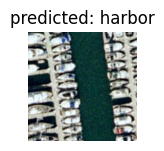

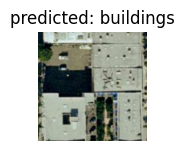

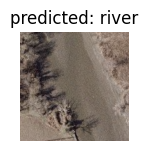

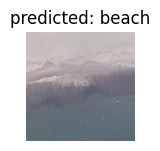

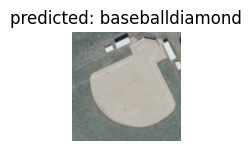

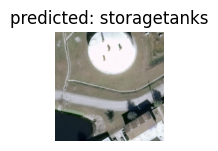

In [ ]:
# Visualize predicted classes
visualize_model(model_conv_ResNet18)

plt.ioff()
plt.show()

In [ ]:
# Test
test_accuracy = calculate_test_accuracy(model_conv_ResNet18)

Test Accuracy: 0.8429


In [ ]:
# Number of parameters
params = sum(p.numel() for p in model_conv_ResNet18.parameters())

trainable_params = sum(p.numel() for p in model_conv_ResNet18.parameters() if p.requires_grad)

print(f'Number of parameters in the model: {params}')
print(f'Number of trainable parameters in the model: {trainable_params}')

Number of parameters in the model: 11187285
Number of trainable parameters in the model: 10773


# VGG16

## Fine tuning VGG16

In [ ]:
# Load a pre-trained VGG16 model
model_ft = models.vgg16(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features

# Modify the top layer for your specific task
model_ft.classifier[6] = nn.Linear(num_ftrs, 21)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Optimize all parameters
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 109MB/s]


In [ ]:
model_ft_VGG16 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.1008 Acc: 0.3743
val Loss: 0.9729 Acc: 0.6857

Epoch 1/24
----------
train Loss: 1.2488 Acc: 0.6190
val Loss: 0.7897 Acc: 0.7730

Epoch 2/24
----------
train Loss: 1.0148 Acc: 0.6952
val Loss: 1.2097 Acc: 0.6238

Epoch 3/24
----------
train Loss: 0.7410 Acc: 0.7714
val Loss: 0.5571 Acc: 0.8317

Epoch 4/24
----------
train Loss: 0.7160 Acc: 0.7800
val Loss: 0.3926 Acc: 0.8587

Epoch 5/24
----------
train Loss: 0.5665 Acc: 0.8057
val Loss: 0.4112 Acc: 0.8730

Epoch 6/24
----------
train Loss: 0.4755 Acc: 0.8524
val Loss: 0.4902 Acc: 0.8238

Epoch 7/24
----------
train Loss: 0.2524 Acc: 0.9181
val Loss: 0.1866 Acc: 0.9429

Epoch 8/24
----------
train Loss: 0.2157 Acc: 0.9324
val Loss: 0.1650 Acc: 0.9429

Epoch 9/24
----------
train Loss: 0.2173 Acc: 0.9295
val Loss: 0.1596 Acc: 0.9524

Epoch 10/24
----------
train Loss: 0.1791 Acc: 0.9486
val Loss: 0.1658 Acc: 0.9524

Epoch 11/24
----------
train Loss: 0.1780 Acc: 0.9410
val Loss: 0.1658 Acc: 0.9476

Ep

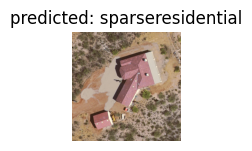

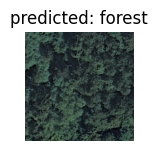

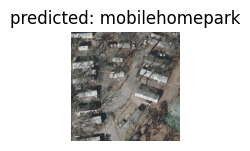

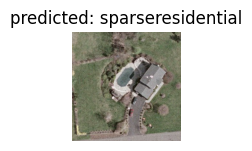

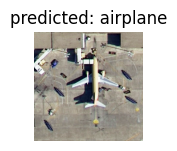

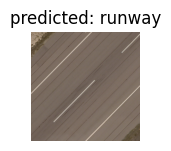

In [ ]:
# Visualize predicted classes
visualize_model(model_ft_VGG16)

plt.ioff()
plt.show()

In [ ]:
# Test
test_accuracy = calculate_test_accuracy(model_ft_VGG16)

Test Accuracy: 0.9524


In [ ]:
# Number of parameters
params = sum(p.numel() for p in model_ft_VGG16.parameters())

trainable_params = sum(p.numel() for p in model_ft_VGG16.parameters() if p.requires_grad)

print(f'Number of parameters in the model: {params}')
print(f'Number of trainable parameters in the model: {trainable_params}')

Number of parameters in the model: 134346581
Number of trainable parameters in the model: 134346581


## Feature extraction VGG16

In [ ]:
# Load a pre-trained VGG16 model
model_conv = torchvision.models.vgg16(pretrained=True)

# Freeze all parameters
for param in model_conv.parameters():
    param.requires_grad = False

# Modify the top layer for your specific task
num_ftrs = model_conv.classifier[6].in_features
model_conv.classifier[6] = nn.Linear(num_ftrs, 21)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Optimize only the parameters of the final layer
optimizer_conv = optim.SGD(model_conv.classifier[6].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [ ]:
model_conv_VGG16 = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3065 Acc: 0.6143
val Loss: 0.5547 Acc: 0.8381

Epoch 1/24
----------
train Loss: 0.6492 Acc: 0.7924
val Loss: 0.4782 Acc: 0.8571

Epoch 2/24
----------
train Loss: 0.5073 Acc: 0.8343
val Loss: 0.4206 Acc: 0.8619

Epoch 3/24
----------
train Loss: 0.5080 Acc: 0.8505
val Loss: 0.4120 Acc: 0.8619

Epoch 4/24
----------
train Loss: 0.4858 Acc: 0.8410
val Loss: 0.3912 Acc: 0.8698

Epoch 5/24
----------
train Loss: 0.4606 Acc: 0.8505
val Loss: 0.4719 Acc: 0.8508

Epoch 6/24
----------
train Loss: 0.4338 Acc: 0.8648
val Loss: 0.3483 Acc: 0.8984

Epoch 7/24
----------
train Loss: 0.4039 Acc: 0.8819
val Loss: 0.3293 Acc: 0.9063

Epoch 8/24
----------
train Loss: 0.4305 Acc: 0.8657
val Loss: 0.3310 Acc: 0.8937

Epoch 9/24
----------
train Loss: 0.3387 Acc: 0.8914
val Loss: 0.3265 Acc: 0.8984

Epoch 10/24
----------
train Loss: 0.3545 Acc: 0.8943
val Loss: 0.3172 Acc: 0.8984

Epoch 11/24
----------
train Loss: 0.3639 Acc: 0.8810
val Loss: 0.3141 Acc: 0.9032

Ep

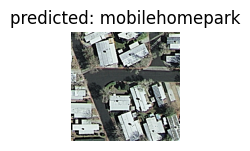

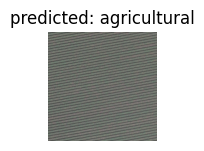

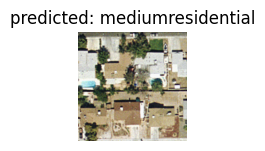

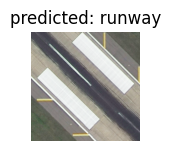

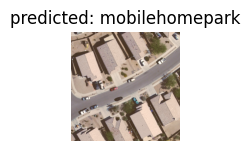

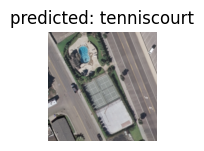

In [ ]:
# Visualize predicted classes
visualize_model(model_conv_VGG16)

plt.ioff()
plt.show()

In [ ]:
# Test
test_accuracy = calculate_test_accuracy(model_conv_VGG16)

Test Accuracy: 0.8952


In [ ]:
# Number of parameters
params = sum(p.numel() for p in model_conv_VGG16.parameters())

trainable_params = sum(p.numel() for p in model_conv_VGG16.parameters() if p.requires_grad)

print(f'Number of parameters in the model: {params}')
print(f'Number of trainable parameters in the model: {trainable_params}')

Number of parameters in the model: 134346581
Number of trainable parameters in the model: 86037


# Train model from scratch

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # Adjust input size dynamically based on your input image size
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten before fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model


In [ ]:
model = SimpleCNN(n_channels=3, n_classes=21)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25)


Epoch 0/24
----------
train Loss: 2.9100 Acc: 0.1086
val Loss: 2.5874 Acc: 0.2222

Epoch 1/24
----------
train Loss: 2.5666 Acc: 0.2000
val Loss: 2.3312 Acc: 0.2746

Epoch 2/24
----------
train Loss: 2.4256 Acc: 0.2314
val Loss: 2.2604 Acc: 0.2746

Epoch 3/24
----------
train Loss: 2.2715 Acc: 0.2657
val Loss: 2.0502 Acc: 0.3619

Epoch 4/24
----------
train Loss: 2.2735 Acc: 0.2914
val Loss: 2.1887 Acc: 0.2873

Epoch 5/24
----------
train Loss: 2.1396 Acc: 0.3181
val Loss: 1.9030 Acc: 0.3603

Epoch 6/24
----------
train Loss: 2.0259 Acc: 0.3324
val Loss: 1.7324 Acc: 0.4683

Epoch 7/24
----------
train Loss: 1.6846 Acc: 0.4695
val Loss: 1.5920 Acc: 0.4857

Epoch 8/24
----------
train Loss: 1.5943 Acc: 0.4914
val Loss: 1.4718 Acc: 0.5206

Epoch 9/24
----------
train Loss: 1.5733 Acc: 0.4819
val Loss: 1.5496 Acc: 0.5127

Epoch 10/24
----------
train Loss: 1.4823 Acc: 0.5219
val Loss: 1.4093 Acc: 0.5413

Epoch 11/24
----------
train Loss: 1.4583 Acc: 0.5400
val Loss: 1.4308 Acc: 0.5270

Ep

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=21, bias=True)
)

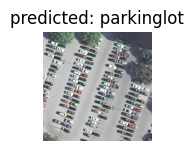

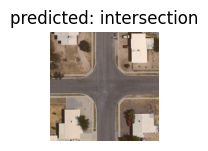

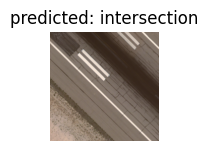

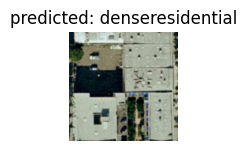

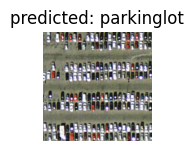

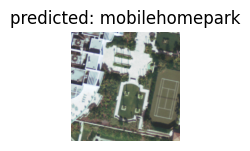

In [ ]:
# Visualize predicted classes
visualize_model(model)

plt.ioff()
plt.show()

In [ ]:
# Test
test_accuracy = calculate_test_accuracy(model)

Test Accuracy: 0.5476


In [ ]:
# Number of parameters
params = sum(p.numel() for p in model.parameters())

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Number of parameters in the model: {params}')
print(f'Number of trainable parameters in the model: {trainable_params}')



Number of parameters in the model: 25712341
Number of trainable parameters in the model: 25712341
